In [1]:
import csv
from pathlib import Path

# 🔴 CHANGE THIS ONLY IF YOUR ROOT PATH CHANGES
ROOT = Path(r"D:\MRI LLM Project\GLI\asnr-miccai-brats2023-gli-challenge-trainingdata\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData")

OUT_CSV = ROOT / "brats_gli_seg_index.csv"

rows = []
missing = 0

# Loop through patient folders
for patient_dir in sorted(p for p in ROOT.iterdir() if p.is_dir() and p.name.startswith("BraTS-GLI-")):
    pid = patient_dir.name

    # 🔍 Find seg file anywhere inside patient folder
    seg_files = list(patient_dir.rglob("*-seg.nii.gz"))

    if seg_files:
        seg_path = str(seg_files[0])
    else:
        seg_path = ""
        missing += 1

    rows.append({
        "id": pid,
        "seg_path": seg_path
    })

# Write CSV
with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["id", "seg_path"])
    writer.writeheader()
    writer.writerows(rows)

print("✅ CSV saved at:", OUT_CSV)
print("✅ Total patients:", len(rows))
print("⚠️ Patients missing seg file:", missing)


✅ CSV saved at: D:\MRI LLM Project\GLI\asnr-miccai-brats2023-gli-challenge-trainingdata\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData\brats_gli_seg_index.csv
✅ Total patients: 1251
⚠️ Patients missing seg file: 0


In [2]:
import nibabel as nib
import numpy as np

seg_path = r"D:\MRI LLM Project\GLI\asnr-miccai-brats2023-gli-challenge-trainingdata\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData\BraTS-GLI-00000-000\BraTS-GLI-00000-000-seg.nii.gz"

img = nib.load(seg_path)
data = img.get_fdata()

print("Shape:", data.shape)
print("Unique labels:", np.unique(data))


Shape: (240, 240, 155)
Unique labels: [0. 1. 2. 3.]


In [3]:
import csv
import json
from pathlib import Path

# 🔴 CHANGE ONLY THIS ROOT IF NEEDED
ROOT = Path(r"D:\MRI LLM Project\GLI\asnr-miccai-brats2023-gli-challenge-trainingdata\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData")

# Input files
CSV_IN  = ROOT / "brats_gli_seg_index.csv"
JSON_IN = ROOT / "global_finding.json"

# Output file
CSV_OUT = ROOT / "brats_gli_seg_with_text.csv"

# Load JSON (id -> text)
with open(JSON_IN, "r", encoding="utf-8") as f:
    text_map = json.load(f)

# Load CSV
with open(CSV_IN, "r", encoding="utf-8") as f:
    rows = list(csv.DictReader(f))

missing = 0

# Merge text into CSV by id
for r in rows:
    pid = r["id"].strip()
    r["text"] = text_map.get(pid, "")
    if r["text"] == "":
        missing += 1

# Write new CSV
fieldnames = list(rows[0].keys())
if "text" not in fieldnames:
    fieldnames.append("text")

with open(CSV_OUT, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(rows)

print("✅ CSV created:", CSV_OUT)
print("Total rows:", len(rows))
print("⚠️ Rows missing text:", missing)


✅ CSV created: D:\MRI LLM Project\GLI\asnr-miccai-brats2023-gli-challenge-trainingdata\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData\brats_gli_seg_with_text.csv
Total rows: 1251
⚠️ Rows missing text: 1021


In [1]:
!pip -q install monai nibabel transformers accelerate


In [10]:
# =========================
# FULL NOTEBOOK CODE (START → END) with FIX for 39 vs 40 shape mismatch
# =========================

import os
import pandas as pd
import numpy as np
import nibabel as nib
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel
from monai.networks.nets import UNet

# -------------------------
# CONFIG
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

CSV_PATH = r"D:\MRI LLM Project\GLI\asnr-miccai-brats2023-gli-challenge-trainingdata\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData\brats_gli_seg_with_text.csv"

BATCH_SIZE = 1            # 3D volumes are big; start with 1
LR = 1e-4
EPOCHS = 1                # start small to verify it runs
MAX_TEXT_LEN = 128
DEBUG_LIMIT = None        # set 20 for quick test, None for full run

# IMPORTANT FIX: UNet needs dimensions divisible by 16 because we downsample 4 times (2^4)
TARGET_SHAPE = (240, 240, 160)  # (H, W, D) 160 is divisible by 16 -> prevents 39 vs 40 mismatch


# -------------------------
# DATASET (with pad/crop fix)
# -------------------------
class BratsTextSegDataset(Dataset):
    def __init__(self, csv_path, tokenizer, max_len=128, debug_limit=None, target_shape=(240, 240, 155)):
        df = pd.read_csv(csv_path)

        # Expect these columns in CSV:
        # - "seg_path" : path to segmentation nifti
        # - "text"     : extracted text prompt
        # Optional:
        # - "patient_id"

        if "seg_path" not in df.columns:
            raise ValueError("CSV must contain a column named 'seg_path'")
        if "text" not in df.columns:
            raise ValueError("CSV must contain a column named 'text'")

        # keep only rows with valid text
        df = df[df["text"].notna()].copy()
        df["text"] = df["text"].astype(str)
        df = df[df["text"].str.len() > 0].copy()

        if debug_limit is not None:
            df = df.head(debug_limit).copy()

        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.target_shape = target_shape

    def _pad_or_crop_3d(self, vol, target_shape):
        """vol: numpy array (H,W,D) -> return exactly (th,tw,td)"""
        th, tw, td = target_shape
        h, w, d = vol.shape

        # center crop if larger
        if h > th:
            s = (h - th) // 2
            vol = vol[s:s + th, :, :]
        if w > tw:
            s = (w - tw) // 2
            vol = vol[:, s:s + tw, :]
        if d > td:
            s = (d - td) // 2
            vol = vol[:, :, s:s + td]

        # pad if smaller
        h, w, d = vol.shape
        pad_h = max(0, th - h)
        pad_w = max(0, tw - w)
        pad_d = max(0, td - d)

        ph0, ph1 = pad_h // 2, pad_h - pad_h // 2
        pw0, pw1 = pad_w // 2, pad_w - pad_w // 2
        pd0, pd1 = pad_d // 2, pad_d - pad_d // 2

        vol = np.pad(
            vol,
            ((ph0, ph1), (pw0, pw1), (pd0, pd1)),
            mode="constant",
            constant_values=0
        )

        # enforce exact shape
        vol = vol[:th, :tw, :td]
        return vol

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        seg_path = row["seg_path"]
        text = row["text"]
        pid = row["patient_id"] if "patient_id" in self.df.columns else ""

        # load nifti segmentation
        seg = nib.load(seg_path).get_fdata().astype(np.float32)  # (H,W,D)

        # FIX: make shape consistent across all samples
        seg = self._pad_or_crop_3d(seg, self.target_shape)       # (240,240,155)

        # add channel dim for UNet: (C,H,W,D)
        seg = np.expand_dims(seg, axis=0)                        # (1,240,240,155)
        seg_t = torch.from_numpy(seg)                            # torch.float32

        # tokenize text
        enc = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "seg": seg_t,  # (1,240,240,155)
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "text": text,
            "id": pid
        }


# -------------------------
# TEXT ENCODER (PubMedBERT)
# -------------------------
TEXT_MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"

tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL_NAME)
text_encoder = AutoModel.from_pretrained(TEXT_MODEL_NAME).to(DEVICE)
text_encoder.eval()  # we won't train BERT at first


# -------------------------
# SIMPLE FUSION MODEL
# - take text embedding
# - project to a small vector
# - inject into UNet via concatenation as an extra channel (broadcast)
# -------------------------
class TextConditionedUNet3D(nn.Module):
    def __init__(self, text_hidden=768, cond_channels=1):
        super().__init__()

        # project CLS embedding -> cond_channels
        self.text_proj = nn.Sequential(
            nn.Linear(text_hidden, 128),
            nn.ReLU(),
            nn.Linear(128, cond_channels)
        )

        # 3D UNet: input_channels = seg_channels(1) + cond_channels
        self.unet = UNet(
            spatial_dims=3,
            in_channels=1 + cond_channels,
            out_channels=1,          # predict same seg volume (demo objective)
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )

    def forward(self, seg, text_emb):
        """
        seg: (B,1,H,W,D)
        text_emb: (B,768)
        """
        B, _, H, W, D = seg.shape

        cond = self.text_proj(text_emb)              # (B, cond_channels)
        cond = cond.view(B, -1, 1, 1, 1)             # (B, cond_channels,1,1,1)
        cond = cond.expand(B, cond.shape[1], H, W, D)  # broadcast to volume

        x = torch.cat([seg, cond], dim=1)            # (B,1+cond,H,W,D)
        out = self.unet(x)                           # (B,1,H,W,D)
        return out


# -------------------------
# DATALOADER
# -------------------------
train_ds = BratsTextSegDataset(
    csv_path=CSV_PATH,
    tokenizer=tokenizer,
    max_len=MAX_TEXT_LEN,
    debug_limit=DEBUG_LIMIT,
    target_shape=TARGET_SHAPE
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# quick sanity check
batch0 = next(iter(train_loader))
print("SANITY seg shape:", batch0["seg"].shape)  # should be [B,1,240,240,155]


# -------------------------
# TRAIN SETUP
# -------------------------
model = TextConditionedUNet3D(text_hidden=768, cond_channels=1).to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=LR)

# simple loss: predict seg from seg + text (demo). Later you can change target.
loss_fn = nn.MSELoss()


# -------------------------
# TRAIN LOOP
# -------------------------
model.train()

for epoch in range(EPOCHS):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    total_loss = 0.0
    n = 0

    for batch in pbar:
        seg = batch["seg"].to(DEVICE)  # (B,1,H,W,D)
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)

        # get text embedding (CLS)
        with torch.no_grad():
            out = text_encoder(input_ids=input_ids, attention_mask=attention_mask)
            text_emb = out.last_hidden_state[:, 0, :]  # CLS (B,768)

        pred = model(seg, text_emb)  # (B,1,H,W,D)

        # demo objective: reconstruct seg
        loss = loss_fn(pred, seg)

        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()
        n += 1
        pbar.set_postfix(loss=loss.item(), avg=total_loss / n)

print("Training done ✅")


DEVICE: cpu
SANITY seg shape: torch.Size([1, 1, 240, 240, 160])


Epoch 1/1: 100%|████████████████████████████████████████████| 230/230 [32:44<00:00,  8.54s/it, avg=0.0927, loss=0.0701]

Training done ✅


In [13]:
torch.save({
    "unet": model.state_dict(),
    "text_encoder": text_encoder.state_dict(),
}, "text_conditioned_unet_stage1.pth")


In [14]:
# SAVE TRAINED MODEL CHECKPOINT
torch.save(
    model.state_dict(),
    "text_conditioned_unet_stage1.pt"
)

print("✅ Model saved as text_conditioned_unet_stage1.pt")


✅ Model saved as text_conditioned_unet_stage1.pt


DEVICE: cpu
Checkpoint selected: text_conditioned_unet_stage1.pt
Using SEG: D:\MRI LLM Project\GLI\asnr-miccai-brats2023-gli-challenge-trainingdata\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData\BraTS-GLI-00006-000\BraTS-GLI-00006-000-seg.nii.gz
✅ Model checkpoint loaded.
✅ Inference done. pred shape: (240, 240, 155)


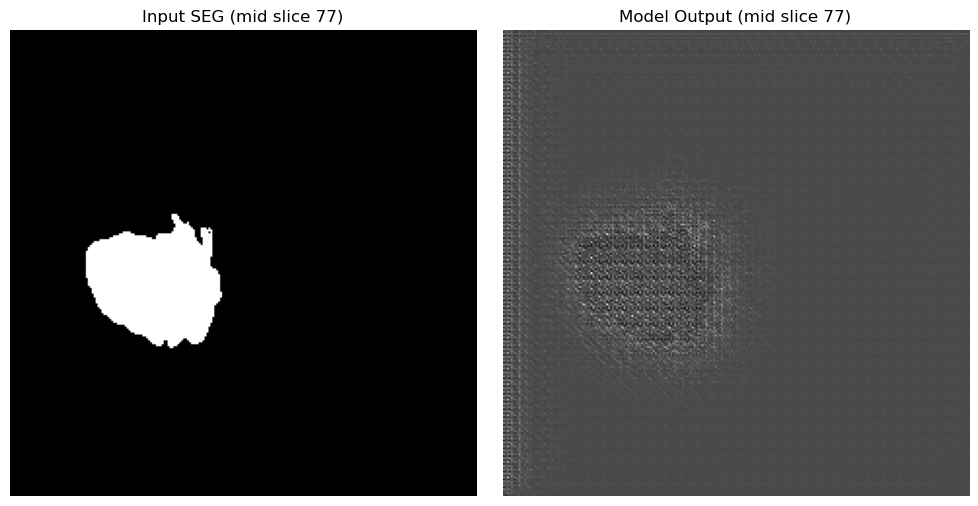


--- TEXT USED ---
 A lesion with approximately round abnormal signal is seen in the left frontal lobe, showing high signal on T1W, T2W, FLAIR sequences, with marked ring-like enhancement on T1C, having unclear borders, measuring about 76*72*69mm. Extensive edema is present in the surrounding brain parenchyma, with compression of the anterior horns of the bilateral lateral ventricles and deviation of midline structures to the right.


In [15]:
# =========================
# STEP 2 (Sanity Check) Code
# Patient: BraTS-GLI-00006-000
# Goal: run 1 forward pass (NO training) + visualize slices
# =========================

import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from monai.networks.nets import UNet

# -------------------------
# CONFIG (keep same as training)
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

CSV_PATH = r"D:\MRI LLM Project\GLI\asnr-miccai-brats2023-gli-challenge-trainingdata\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData\brats_gli_seg_with_text.csv"

PATIENT_ID = "BraTS-GLI-00006-000"

PATIENT_TEXT = """A lesion with approximately round abnormal signal is seen in the left frontal lobe, showing high signal on T1W, T2W, FLAIR sequences, with marked ring-like enhancement on T1C, having unclear borders, measuring about 76*72*69mm. Extensive edema is present in the surrounding brain parenchyma, with compression of the anterior horns of the bilateral lateral ventricles and deviation of midline structures to the right."""

MAX_TEXT_LEN = 128

# ---- model checkpoint (update if your filename is different)
# If you don't remember name, this auto-picks the newest .pt in your notebook folder.
CKPT_PATH = None
pt_files = sorted(glob.glob("*.pt"), key=os.path.getmtime)
if len(pt_files) > 0:
    CKPT_PATH = pt_files[-1]
print("Checkpoint selected:", CKPT_PATH)

# -------------------------
# HELPERS
# -------------------------
def load_nii(path):
    """Loads a NIfTI and returns numpy array (float32)."""
    arr = nib.load(path).get_fdata().astype(np.float32)
    return arr

def ensure_3d(arr):
    """
    Ensure we end with (H,W,D).
    If your seg is (H,W,D) already -> ok.
    If it's (H,W,D,1) -> squeeze.
    If it's (1,H,W,D) -> squeeze.
    """
    if arr.ndim == 4:
        # common cases: (H,W,D,1) or (1,H,W,D)
        if arr.shape[-1] == 1:
            arr = arr[..., 0]
        elif arr.shape[0] == 1:
            arr = arr[0]
    return arr

def pad_to_multiple_3d(x, multiple=16):
    """
    x: torch tensor (B,C,H,W,D)
    Pads H,W,D so each becomes divisible by `multiple`.
    Returns padded_x, (pad_h, pad_w, pad_d) for later unpad.
    """
    B, C, H, W, D = x.shape
    def pad_amt(n):
        r = n % multiple
        return 0 if r == 0 else (multiple - r)

    ph = pad_amt(H)
    pw = pad_amt(W)
    pd = pad_amt(D)

    # pad format for torch.nn.functional.pad on 5D: (D_left, D_right, W_left, W_right, H_left, H_right)
    # We'll pad only on the "right" side to keep it simple.
    x = torch.nn.functional.pad(x, (0, pd, 0, pw, 0, ph), mode="constant", value=0.0)
    return x, (ph, pw, pd)

def unpad_3d(x, pads):
    """Remove right-side padding from (B,C,H,W,D)."""
    ph, pw, pd = pads
    if ph > 0:
        x = x[:, :, :-ph, :, :]
    if pw > 0:
        x = x[:, :, :, :-pw, :]
    if pd > 0:
        x = x[:, :, :, :, :-pd]
    return x

# -------------------------
# MODEL DEFINITION (same structure as training)
# -------------------------
class TextConditionedUNet3D(nn.Module):
    def __init__(self, text_dim=768, cond_channels=8):
        super().__init__()
        self.cond_channels = cond_channels
        self.text_proj = nn.Linear(text_dim, cond_channels)

        # UNet expects input channels = 1 (seg) + cond_channels
        self.unet = UNet(
            spatial_dims=3,
            in_channels=1 + cond_channels,
            out_channels=1,
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2),
            num_res_units=2,
        )

    def forward(self, seg, text_emb):
        """
        seg: (B,1,H,W,D)
        text_emb: (B,768)
        """
        B, _, H, W, D = seg.shape
        cond = self.text_proj(text_emb)                  # (B,cond_channels)
        cond = cond[:, :, None, None, None]              # (B,cond_channels,1,1,1)
        cond = cond.expand(B, cond.shape[1], H, W, D)    # (B,cond_channels,H,W,D)
        x = torch.cat([seg, cond], dim=1)                # (B,1+cond_channels,H,W,D)
        out = self.unet(x)                               # (B,1,H,W,D)
        return out

# -------------------------
# LOAD CSV + GET PATHS
# -------------------------
df = pd.read_csv(CSV_PATH)

# Try common column names used in our pipeline
possible_id_cols = ["patient_id", "BraTS_ID", "subject_id", "id", "case_id"]
id_col = None
for c in possible_id_cols:
    if c in df.columns:
        id_col = c
        break
if id_col is None:
    raise ValueError(f"Could not find patient id column. Available columns: {list(df.columns)}")

row = df[df[id_col] == PATIENT_ID]
if len(row) == 0:
    raise ValueError(f"Patient {PATIENT_ID} not found in CSV under column '{id_col}'.")

row = row.iloc[0]

# Try common seg path column names
possible_seg_cols = ["seg_path", "seg", "mask_path", "label_path", "segmentation_path"]
seg_col = None
for c in possible_seg_cols:
    if c in df.columns:
        seg_col = c
        break
if seg_col is None:
    raise ValueError(f"Could not find segmentation path column. Available columns: {list(df.columns)}")

seg_path = row[seg_col]
if not os.path.exists(seg_path):
    raise FileNotFoundError(f"Seg file not found: {seg_path}")

print("Using SEG:", seg_path)

# -------------------------
# LOAD TEXT ENCODER (same as training)
# -------------------------
# If you used PubMedBERT during training, keep it exactly:
TEXT_MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"

tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL_NAME)
text_encoder = AutoModel.from_pretrained(TEXT_MODEL_NAME).to(DEVICE)
text_encoder.eval()

# -------------------------
# LOAD MODEL + CHECKPOINT
# -------------------------
model = TextConditionedUNet3D(text_dim=768, cond_channels=8).to(DEVICE)
model.eval()

if CKPT_PATH is None:
    raise FileNotFoundError("No .pt checkpoint found in this notebook folder. Put your trained .pt here or set CKPT_PATH manually.")

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)

# handle both: full dict with 'model_state_dict' OR raw state_dict
if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
    model.load_state_dict(ckpt["model_state_dict"], strict=True)
else:
    model.load_state_dict(ckpt, strict=True)

print("✅ Model checkpoint loaded.")

# -------------------------
# PREPARE INPUTS
# -------------------------
seg_np = ensure_3d(load_nii(seg_path))

# normalize seg a bit (optional, but helps)
# If seg is binary/labels, keep it as 0/1.
# If it's {0,1,2,3}, we compress to 0/1 for this demo.
seg_bin = (seg_np > 0).astype(np.float32)

# to torch: (B,1,H,W,D)
seg_t = torch.from_numpy(seg_bin)[None, None, ...].to(DEVICE)

# pad so UNet downsampling doesn't break skip connections
seg_t, pads = pad_to_multiple_3d(seg_t, multiple=16)

# tokenize text
enc = tokenizer(
    PATIENT_TEXT,
    padding="max_length",
    truncation=True,
    max_length=MAX_TEXT_LEN,
    return_tensors="pt",
)
input_ids = enc["input_ids"].to(DEVICE)
attention_mask = enc["attention_mask"].to(DEVICE)

# -------------------------
# INFERENCE (NO GRAD)
# -------------------------
with torch.no_grad():
    out = text_encoder(input_ids=input_ids, attention_mask=attention_mask)
    text_emb = out.last_hidden_state[:, 0, :]  # CLS (B,768)

    pred = model(seg_t, text_emb)              # (B,1,H,W,D)

# unpad back to original size
pred = unpad_3d(pred, pads)

pred_np = pred.detach().cpu().numpy()[0, 0]   # (H,W,D)

print("✅ Inference done. pred shape:", pred_np.shape)

# -------------------------
# VISUALIZE (middle slice)
# -------------------------
H, W, D = pred_np.shape
mid = D // 2

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(seg_bin[:, :, mid], cmap="gray")
axs[0].set_title(f"Input SEG (mid slice {mid})")
axs[0].axis("off")

axs[1].imshow(pred_np[:, :, mid], cmap="gray")
axs[1].set_title(f"Model Output (mid slice {mid})")
axs[1].axis("off")

plt.tight_layout()
plt.show()

# OPTIONAL: print text used (to confirm)
print("\n--- TEXT USED ---\n", PATIENT_TEXT)
